# **Ischemic Heart Disease Prediction** using ***Deep Stacking***

***TABLE OF CONTENTS:***
1. [Importing libraries & Reading dataset](#1)
2. [Data Description](#2)
3. [Analyzing Data](#3)
4. [Data Pre-processing](#4)
5. [Train-Test Split](#5)
6. [Modelling & Hyperparameter Optimization](#6)
7. [Model selection & Conclusion](#7)

# 1.Importing libraries & Reading dataset <a name="1"></a>

In [ ]:
# important libraries for data science
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# library to save models
import joblib

# Machine learning Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import  SVC # support vector classifier
from sklearn.neighbors import KNeighborsClassifier # knn
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB # naive_bayes
from sklearn.neural_network import MLPClassifier # neural_network
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

# for hyper-parameter optimization
from sklearn.model_selection import GridSearchCV

# importing libraries to calculate time & ignore warnings
import time
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# importing libraries for train_test_split and check model performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve


# to clear messy console
from google.colab import output
output.clear()

In [ ]:
# installing a catboost Algorithm
!pip install catboost
import catboost as cbc

# installing Superlearner Algorithm
!pip install mlens
from mlens.ensemble import SuperLearner

# setting figure styles
sns.set_style('darkgrid')
sns.set_palette('Set2')

     |████████████████████████████████| 67.4 MB 29 kB/s 
     |████████████████████████████████| 227 kB 4.1 MB/s 


[MLENS] backend: threading


In [ ]:
# loading dataset
df = pd.read_csv('/content/heart.csv')
df.head() # show the first 5 rows

# 2.Data Description<a name="2"></a>

In [ ]:
# Is there any NULL value in our dataset
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [ ]:
# installing pandas-profiling
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

     - 34.6 MB 515 kB/s
     |████████████████████████████████| 10.1 MB 26.1 MB/s 
     |████████████████████████████████| 636 kB 41.7 MB/s 
     |████████████████████████████████| 102 kB 58.7 MB/s 
     |████████████████████████████████| 675 kB 35.3 MB/s 
     |████████████████████████████████| 3.1 MB 32.6 MB/s 
     |████████████████████████████████| 62 kB 930 kB/s 
     |████████████████████████████████| 812 kB 28.7 MB/s 
     |████████████████████████████████| 28.5 MB 52 kB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-3.0.0-py2.py3-none-any.whl size=248524 sha256=7a239f85f7e8ec1c90e840794e1674f28baf850164501bc5f00879c058c82de1
  Stored in directory: /tmp/pip-ephem-wheel-cache-wz9x0928/wheels/cc/d5/09/083fb07c9363a2f45854b0e3a7de7d7c560f07da74b9e9769d
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=b426b2643282663d090d1bd9562b20d0fd5443cfdc24385b6b07f2e541af8e1e
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14

In [ ]:
# importing pandas_profiling and generating report
import pandas_profiling as pp
pp.ProfileReport(df)

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 3.Analyzing Data<a name="3"></a>

### Univariate Feature Selection
Univariate Selction — Statistical tests may be used to pick certain features that have the best relationship to the performance variable.
The scikit-learn library provides the SelectKBest class that can be used to select a specific number of features in a suite of different statistical tests.
The following example uses the chi-squared (chi2) statistical test for non-negative features to select 10 of the best features.

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
data = df.copy()
X = data.iloc[:,0:13]  
y = data.iloc[:,-1]    

bestfeatures = SelectKBest(score_func=chi2)
fit = bestfeatures.fit(X,y)

#concat columns & scores dataframes for better visualization 
featureScores = pd.concat( 
    [pd.DataFrame(X.columns), pd.DataFrame(fit.scores_)], axis=1)
featureScores.columns = ['Specs','Score'] 

print(featureScores.nlargest(13,'Score'))  # print 13 best features

# df.drop('fbs',axis=1,inplace=True)

       Specs       Score
7    thalach  188.320472
9    oldpeak   72.644253
11        ca   66.440765
2         cp   62.598098
8      exang   38.914377
4       chol   23.936394
0        age   23.286624
3   trestbps   14.823925
10     slope    9.804095
1        sex    7.576835
12      thal    5.791853
6    restecg    2.978271
5        fbs    0.202934


### Correlation Matrix - Heatmap
Correlation indicates how the features are related to each other or to the target variable.
The correlation may be positive (increase in one value of the feature increases the value of the target variable) or negative (increase in one value of the feature decreases the value of the target variable)
Heatmap makes it easy to classify the features are most relevant to the target variable, and we will plot the associated features of the heatmap using the seaborn library.

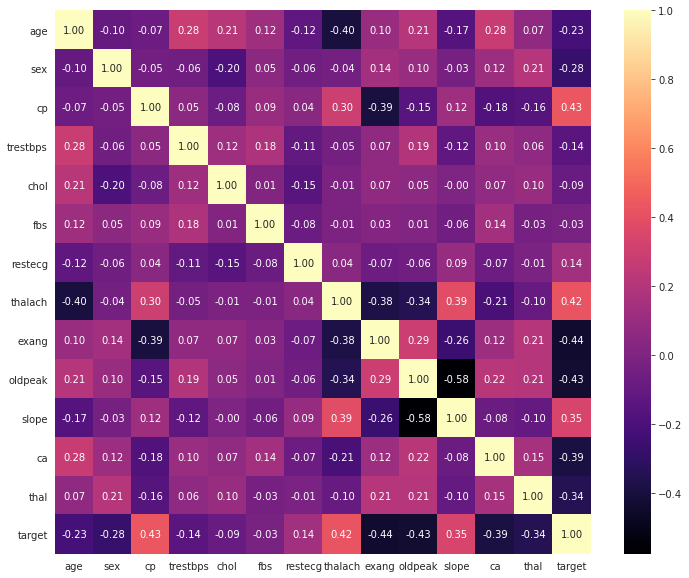

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),annot=True,cmap="magma",fmt='.2f')

# 4.Data Pre-processing<a name="4"></a>

### Pre-processing

In [ ]:
# Changing column names to understand them a bit better
df.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg_type', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope_type', 'num_major_vessels', 'thalassemia_type', 'target']

df.columns

Index(['age', 'sex', 'chest_pain_type', 'resting_blood_pressure',
       'cholesterol', 'fasting_blood_sugar', 'rest_ecg_type',
       'max_heart_rate_achieved', 'exercise_induced_angina', 'st_depression',
       'st_slope_type', 'num_major_vessels', 'thalassemia_type', 'target'],
      dtype='object')

In [ ]:
# 4 Catagorical columns in our dataset: cp, restecg, slope, thal
# Now we generate categorical columns values

#cp - chest_pain_type
df.loc[df['chest_pain_type'] == 0, 'chest_pain_type'] = 'asymptomatic'
df.loc[df['chest_pain_type'] == 1, 'chest_pain_type'] = 'atypical angina'
df.loc[df['chest_pain_type'] == 2, 'chest_pain_type'] = 'non-anginal pain'
df.loc[df['chest_pain_type'] == 3, 'chest_pain_type'] = 'typical angina'

#restecg - rest_ecg_type
df.loc[df['rest_ecg_type'] == 0, 'rest_ecg_type'] = 'left ventricular hypertrophy'
df.loc[df['rest_ecg_type'] == 1, 'rest_ecg_type'] = 'normal'
df.loc[df['rest_ecg_type'] == 2, 'rest_ecg_type'] = 'ST-T wave abnormality'

#slope - st_slope_type
df.loc[df['st_slope_type'] == 0, 'st_slope_type'] = 'downsloping'
df.loc[df['st_slope_type'] == 1, 'st_slope_type'] = 'flat'
df.loc[df['st_slope_type'] == 2, 'st_slope_type'] = 'upsloping'

#thal - thalassemia_type
df.loc[df['thalassemia_type'] == 0, 'thalassemia_type'] = 'nothing'
df.loc[df['thalassemia_type'] == 1, 'thalassemia_type'] = 'fixed defect'
df.loc[df['thalassemia_type'] == 2, 'thalassemia_type'] = 'normal'
df.loc[df['thalassemia_type'] == 3, 'thalassemia_type'] = 'reversable defect'


In [ ]:
df.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg_type,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope_type,num_major_vessels,thalassemia_type,target
0,63,1,typical angina,145,233,1,left ventricular hypertrophy,150,0,2.3,downsloping,0,fixed defect,1
1,37,1,non-anginal pain,130,250,0,normal,187,0,3.5,downsloping,0,normal,1
2,41,0,atypical angina,130,204,0,left ventricular hypertrophy,172,0,1.4,upsloping,0,normal,1
3,56,1,atypical angina,120,236,0,normal,178,0,0.8,upsloping,0,normal,1
4,57,0,asymptomatic,120,354,0,normal,163,1,0.6,upsloping,0,normal,1


### One Hot Encoding

In [ ]:
data = pd.get_dummies(df, drop_first=False)
data.columns

Index(['age', 'sex', 'resting_blood_pressure', 'cholesterol',
       'fasting_blood_sugar', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'num_major_vessels',
       'target', 'chest_pain_type_asymptomatic',
       'chest_pain_type_atypical angina', 'chest_pain_type_non-anginal pain',
       'chest_pain_type_typical angina', 'rest_ecg_type_ST-T wave abnormality',
       'rest_ecg_type_left ventricular hypertrophy', 'rest_ecg_type_normal',
       'st_slope_type_downsloping', 'st_slope_type_flat',
       'st_slope_type_upsloping', 'thalassemia_type_fixed defect',
       'thalassemia_type_normal', 'thalassemia_type_nothing',
       'thalassemia_type_reversable defect'],
      dtype='object')

In [ ]:
df_temp = data['thalassemia_type_fixed defect']
data = pd.get_dummies(df, drop_first=True)
data.head()

,age,sex,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,num_major_vessels,target,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,rest_ecg_type_left ventricular hypertrophy,rest_ecg_type_normal,st_slope_type_flat,st_slope_type_upsloping,thalassemia_type_normal,thalassemia_type_nothing,thalassemia_type_reversable defect
0,63,1,145,233,1,150,0,2.3,0,1,0,0,1,1,0,0,0,0,0,0
1,37,1,130,250,0,187,0,3.5,0,1,0,1,0,0,1,0,0,1,0,0
2,41,0,130,204,0,172,0,1.4,0,1,1,0,0,1,0,0,1,1,0,0
3,56,1,120,236,0,178,0,0.8,0,1,1,0,0,0,1,0,1,1,0,0
4,57,0,120,354,0,163,1,0.6,0,1,0,0,0,0,1,0,1,1,0,0


In [ ]:
frames = [data, df_temp]
result = pd.concat(frames,axis=1)

result.head()

,age,sex,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,num_major_vessels,target,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,rest_ecg_type_left ventricular hypertrophy,rest_ecg_type_normal,st_slope_type_flat,st_slope_type_upsloping,thalassemia_type_normal,thalassemia_type_nothing,thalassemia_type_reversable defect,thalassemia_type_fixed defect
0,63,1,145,233,1,150,0,2.3,0,1,0,0,1,1,0,0,0,0,0,0,1
1,37,1,130,250,0,187,0,3.5,0,1,0,1,0,0,1,0,0,1,0,0,0
2,41,0,130,204,0,172,0,1.4,0,1,1,0,0,1,0,0,1,1,0,0,0
3,56,1,120,236,0,178,0,0.8,0,1,1,0,0,0,1,0,1,1,0,0,0
4,57,0,120,354,0,163,1,0.6,0,1,0,0,0,0,1,0,1,1,0,0,0


In [ ]:
result.drop('thalassemia_type_nothing',axis=1,inplace=True)
resultc = result.copy()

# 5.Train-Test Split<a name="5"></a>

In [ ]:
new_result = result
X = new_result.drop('target', axis = 1)
y = new_result['target']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# X_train=(X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train)).values
# X_test=(X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test)).values

X_val = X_test
y_val = y_test
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)


# 6.Modelling & Hyperparameter Optimization<a name="6"></a>

## Single Classifiers

In [ ]:
# Helper Functions

# Function to print best hyperparamaters: 
def print_best_params(gd_model):
    param_dict = gd_model.best_estimator_.get_params()
    model_str = str(gd_model.estimator).split('(')[0]
    print("\n*** {} Best Parameters ***".format(model_str))
    for k in param_dict:
        print("{}: {}".format(k, param_dict[k]))
    print()

# Function to print for each combination of hyperparamaters
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [ ]:
# LOGISTIC REGRESSION

param_grid_logre = {'C': [1]}
logre = GridSearchCV(LogisticRegression(max_iter=3000), param_grid=param_grid_logre, cv=5, verbose=3)
logre = logre.fit(X_train, y_train.values.ravel())

# joblib.dump(logre.best_estimator_, '/content/models/LR.pkl')
output.clear()
print('LOGISTIC REGRESSION test score: %.3f' % (logre.score(X_val, y_val)))

LOGISTIC REGRESSION test score: 0.869


In [ ]:
# SVM
param_grid_svc = {'kernel': ['rbf'],'C': [1]}
svc = GridSearchCV(SVC(), param_grid=param_grid_svc, cv=5, verbose=3)
svc = svc.fit(X_train, y_train.values.ravel())

# joblib.dump(svc.best_estimator_, '/content/models/SVC.pkl')
output.clear()
print('SVC test score: %.3f' % (svc.score(X_val, y_val)))

SVC test score: 0.689


In [ ]:
# Neural Network
param_grid_mlp = {
    'hidden_layer_sizes': [(380,)], 
    'activation': ['relu'], 'learning_rate': ['invscaling']
}
mlp = GridSearchCV(MLPClassifier(), param_grid_mlp, cv=5)
mlp = mlp.fit(X_train, y_train.values.ravel())

# joblib.dump(svc.best_estimator_, '/content/models/MLP.pkl')
output.clear()
print('MLP test score: %.3f' % (mlp.score(X_val, y_val)))

MLP test score: 0.869


In [ ]:
# RF
param_grid_rfc = {'n_estimators': [250], 'max_depth': [None]}
rfc = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_rfc, cv=5, verbose=3)
rfc = rfc.fit(X_train, y_train.values.ravel())

# joblib.dump(rfc.best_estimator_, '/content/models/RF.pkl')
output.clear()
print('RF test score: %.3f' % (rfc.score(X_val, y_val)))

RF test score: 0.869


In [ ]:
# GBC
param_grid_gbc = {'n_estimators': [250], 'max_depth': [1],'learning_rate': [0.01]}
gbc = GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid_gbc, cv=5, verbose=3)
gbc = gbc.fit(X_train, y_train.values.ravel())

# joblib.dump(gbc.best_estimator_, '/content/models/GBC.pkl')
output.clear()
print('GBC test score: %.3f' % (gbc.score(X_val, y_val)))

GBC test score: 0.836


In [ ]:
# CB
param_grid_cb = {}
cb = GridSearchCV(cbc.CatBoostClassifier(), param_grid=param_grid_cb, cv=5, verbose=3)
cb = cb.fit(X_train, y_train.values.ravel())

# joblib.dump(cb.best_estimator_, '/content/models/CB.pkl')
output.clear()
print('CB test score: %.3f' % (cb.score(X_val, y_val)))

CB test score: 0.852


In [ ]:
# KNN
param_grid_knn = {}
knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn, cv=5, verbose=3)
knn = knn.fit(X_train, y_train.values.ravel())

# joblib.dump(knn.best_estimator_, '/content/models/KNN.pkl')
output.clear()
print('KNN test score: %.3f' % (knn.score(X_val, y_val)))

KNN test score: 0.639


In [ ]:
# DT
param_grid_dt = {'max_depth' : [3]}
dt = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid_dt, cv=5, verbose=3)
dt = dt.fit(X_train, y_train.values.ravel())

# joblib.dump(dt.best_estimator_, '/content/models/DT.pkl')
output.clear()
print('DT test score: %.3f' % (dt.score(X_val, y_val)))

DT test score: 0.787


In [ ]:
# NB
param_grid_nb = {}
nb = GridSearchCV(GaussianNB(), param_grid=param_grid_nb, cv=5, verbose=3)
nb = nb.fit(X_train, y_train.values.ravel())

# joblib.dump(nb.best_estimator_, '/content/models/NB.pkl')
output.clear()
print('NB test score: %.3f' % (nb.score(X_val, y_val)))

NB test score: 0.885


## Ensembles & Meta-Modelling

In [ ]:
# Hybrid Model 1 using LG & RF

param_grid_hm1 = {}
lrc1 = LogisticRegression(max_iter=2000, multi_class='auto', class_weight='balanced')
rf1 = RandomForestClassifier(class_weight='balanced')

voting_clf = VotingClassifier(estimators = [('lrc1', lrc1), ('rf1', rf1)], voting='soft')
hm1 = GridSearchCV(voting_clf, param_grid=param_grid_hm1, cv=5, verbose=3)
hm1 = hm1.fit(X_train, y_train.values.ravel())

# joblib.dump(hm1.best_estimator_, '/content/models/VC1.pkl')
output.clear()
print('Voting Classifier 1 test score: %.3f' % (hm1.score(X_val, y_val)))


Voting Classifier 1 test score: 0.885


In [ ]:
# Hybrid Model 2 using MLP & NB

param_grid_hm2 = {}
voting_clf = VotingClassifier(estimators = [
                                            # ('logre', logre), 
                                            ('mlp', mlp.best_estimator_),
                                            # ('rfc', rfc),
                                            # ('cb', cb),
                                            ('nb', nb.best_estimator_)
                                            ], voting='soft')
hm2 = GridSearchCV(voting_clf, param_grid=param_grid_hm2, cv=5, verbose=3)
hm2 = hm2.fit(X_train, y_train.values.ravel())

# joblib.dump(hm2.best_estimator_, '/content/models/VC2.pkl')
output.clear()
print('Voting Classifier 2 test score: %.3f' % (hm2.score(X_val, y_val)))

Voting Classifier 2 test score: 0.869


In [ ]:
# Stacking Classifier

estimator_list = [
                 ('logre', logre.best_estimator_),
                #  ('svc', svc.best_estimator_),
                 ('rfc', rfc.best_estimator_),
                 ('gbc', gbc.best_estimator_),
                #  ('knn', knn.best_estimator_),
                 ('nb', nb.best_estimator_),
                 ('mlp', mlp.best_estimator_),
                  ('cb', cb.best_estimator_)
]

param_grid_sc = {}
stack_model = StackingClassifier(
    estimators=estimator_list, final_estimator=LogisticRegression()
)
sc = GridSearchCV(stack_model, param_grid=param_grid_sc, cv=5, verbose=3)
sc = sc.fit(X_train, y_train.values.ravel())

# joblib.dump(sc.best_estimator_, '/content/models/SC.pkl')
output.clear()
print('Stacking Classifier test score: %.3f' % (sc.score(X_val, y_val)))

Stacking Classifier test score: 0.885


In [ ]:
# Super Learner
 
# create a list of base-models
def get_models():
  models = list()
  models.append(nb.best_estimator_)
  models.append(logre.best_estimator_)
  models.append(rfc.best_estimator_)
  models.append(cb.best_estimator_)
  return models
 
# create the super learner
def get_super_learner(X):
  ensemble = SuperLearner(scorer=accuracy_score, folds=10, shuffle=True, )
  models = get_models()
  ensemble.add(models)
  ensemble.add_meta(LogisticRegression(solver='lbfgs'))
  return ensemble

ensemble = get_super_learner(X_train.to_numpy())
ensemble.fit(X_train.to_numpy(), y_train.to_numpy())

# joblib.dump(ensemble, '/content/models/SL.pkl')
output.clear()
yhat = ensemble.predict(X_test.to_numpy())
print('Super Learner: %.3f' % (accuracy_score(y_test.to_numpy(), yhat) * 100))

Super Learner: 90.164


# 7.Model selection & Conclusion<a name="6"></a>

In [ ]:
# Loading saved models
models = {}
for mdl in ['LR', 'SVC', 'MLP', 'RF', 'GBC', 'CB', 'KNN', 'DT', 'NB', 'VC1', 'VC2', 'SC', 'SL']:
  models[mdl] = joblib.load('/content/models/{}.pkl'.format(mdl))

In [ ]:
def evaluate_model(name, model, features, labels):
  start = time.time()
  pred = model.predict(features)
  end = time.time()

  features = features.to_numpy()
  labels = labels.to_numpy()
  # pred = pred.to_numpy()

  accuracy = round(accuracy_score(labels, pred), 4)
  precision = round(precision_score(labels, pred),3)
  recall = round(recall_score(labels, pred),3)
  print('{} -- Accuracy: {} / Precision: {} / Recall: {} / Latency: {}ms'.format(name,
                                                                                 accuracy,
                                                                                 precision,
                                                                                 recall,
                                                                                 round((end-start), 3)))

In [ ]:
# Evaluate models on the Test set
for name, mdl in models.items():
  evaluate_model(name, mdl, X_val, y_val)

LR -- Accuracy: 0.8689 / Precision: 0.882 / Recall: 0.882 / Latency: 0.003ms
SVC -- Accuracy: 0.6885 / Precision: 0.674 / Recall: 0.853 / Latency: 0.002ms
MLP -- Accuracy: 0.6885 / Precision: 0.674 / Recall: 0.853 / Latency: 0.001ms
RF -- Accuracy: 0.8689 / Precision: 0.882 / Recall: 0.882 / Latency: 0.028ms
GBC -- Accuracy: 0.8361 / Precision: 0.853 / Recall: 0.853 / Latency: 0.002ms
CB -- Accuracy: 0.8525 / Precision: 0.857 / Recall: 0.882 / Latency: 0.003ms
KNN -- Accuracy: 0.6393 / Precision: 0.688 / Recall: 0.647 / Latency: 0.004ms
DT -- Accuracy: 0.7869 / Precision: 0.818 / Recall: 0.794 / Latency: 0.001ms
NB -- Accuracy: 0.8852 / Precision: 0.935 / Recall: 0.853 / Latency: 0.001ms
VC1 -- Accuracy: 0.8852 / Precision: 0.886 / Recall: 0.912 / Latency: 0.011ms
VC2 -- Accuracy: 0.8689 / Precision: 0.906 / Recall: 0.853 / Latency: 0.004ms
SC -- Accuracy: 0.8852 / Precision: 0.886 / Recall: 0.912 / Latency: 0.05ms
SL -- Accuracy: 0.9016 / Precision: 0.912 / Recall: 0.912 / Latency: 0.

In [ ]:
# Prepraring performance data for Visualization

mdlName = list()
accScore = list()
preScore = list()
recScore = list()

for name, mdl in models.items():  
  pred = mdl.predict(X_val)
  accuracy = round(accuracy_score(y_val, pred), 3)
  precision = round(precision_score(y_val, pred),3)
  recall = round(recall_score(y_val, pred),3)

  mdlName.append(name)
  accScore.append(accuracy)
  preScore.append(precision)
  recScore.append(recall)

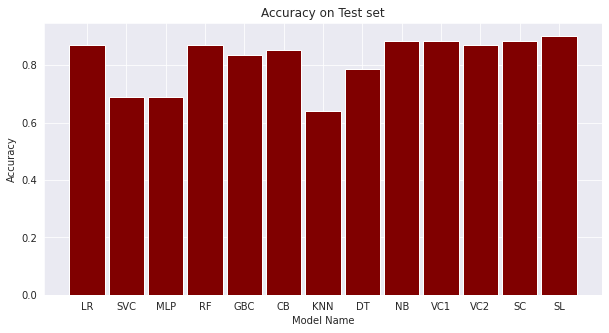

In [ ]:
fig = plt.figure(figsize = (10, 5))
plt.bar(mdlName, accScore, color ='maroon', width = 0.9)
 
plt.xlabel("Model Name")
plt.ylabel("Accuracy")
plt.title("Accuracy on Test set")
plt.show()

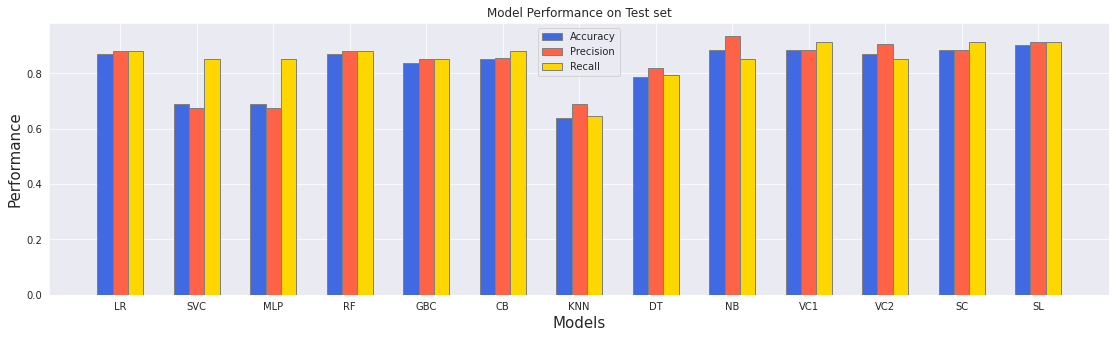

In [ ]:
# Performance Visualization

# Set width of bar
barWidth = 0.2
fig = plt.subplots(figsize =(19, 5))

# Set position of bar on X axis
br1 = np.arange(len(accScore))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, accScore, color ='royalblue', width = barWidth,
		edgecolor ='grey', label ='Accuracy')
plt.bar(br2, preScore, color ='tomato', width = barWidth,
		edgecolor ='grey', label ='Precision')
plt.bar(br3, recScore, color ='gold', width = barWidth,
		edgecolor ='grey', label ='Recall')

# Adding Xticks
plt.xlabel('Models', fontsize = 15)
plt.ylabel('Performance', fontsize = 15)
plt.title("Model Performance on Test set")
plt.xticks([r + barWidth for r in range(len(accScore))],
		mdlName)
plt.legend()
plt.show()


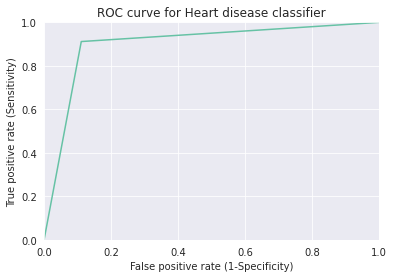

In [ ]:
# ROC Curve
supl = models['SL']
yhat = supl.predict(X_test.to_numpy())

fpr, tpr, thresholds = roc_curve(y_test.to_numpy(), yhat)
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Heart disease classifier')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)

ROC Interpretation

![](https://46gyn61z4i0t1u1pnq2bbk2e-wpengine.netdna-ssl.com/wp-content/uploads/2018/07/ROC-curve-1-768x631.jpg)

In [ ]:
# AUC Score
import sklearn
sklearn.metrics.roc_auc_score(y_test.to_numpy(), yhat)

0.9003267973856208

**Conclusion**

- The Area under the ROC curve is 90.03% which is somewhat satisfactory.
- The model predicted with 90.16% accuracy. The model is more specific than sensitive.